<a href="https://colab.research.google.com/github/nasarar/Post_Covid19_Vacation_Projection/blob/Joseph/covid_19_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [3]:
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df= pd.read_csv(
    'https://covid.ourworldindata.org/data/owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [5]:
country_list = df.location.value_counts().keys()
country_list

Index(['Argentina', 'Mexico', 'Thailand', 'Peru', 'Taiwan', 'South Korea',
       'United States', 'China', 'North America', 'Japan',
       ...
       'Jersey', 'Wallis and Futuna', 'Aruba', 'Curacao', 'Nauru', 'Tonga',
       'Sint Maarten (Dutch part)', 'Turkmenistan', 'Tuvalu',
       'Bonaire Sint Eustatius and Saba'],
      dtype='object', length=226)

#Arima Model

In [6]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 4.9MB/s 
     |████████████████████████████████| 9.5MB 29.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [7]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

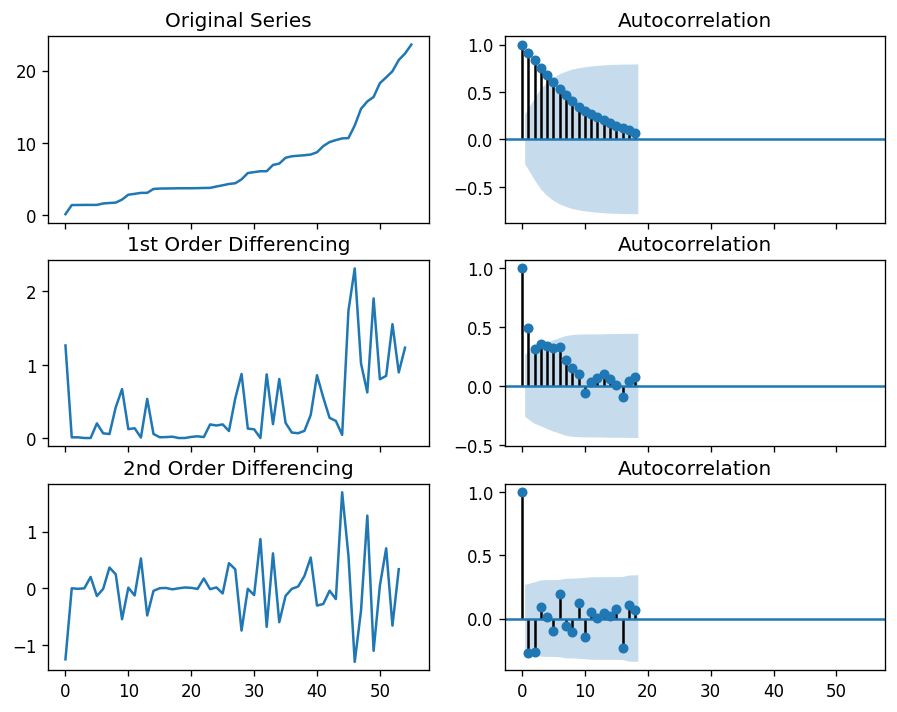

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=74.736, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=88.141, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=85.596, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=73.805, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=86.141, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=73.985, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=75.324, Time=0.24 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=72.852, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=73.973, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=73.275, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=83.600, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=74.558, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.983 seconds
                               SARIMAX Results                                
Dep. Variable:                   

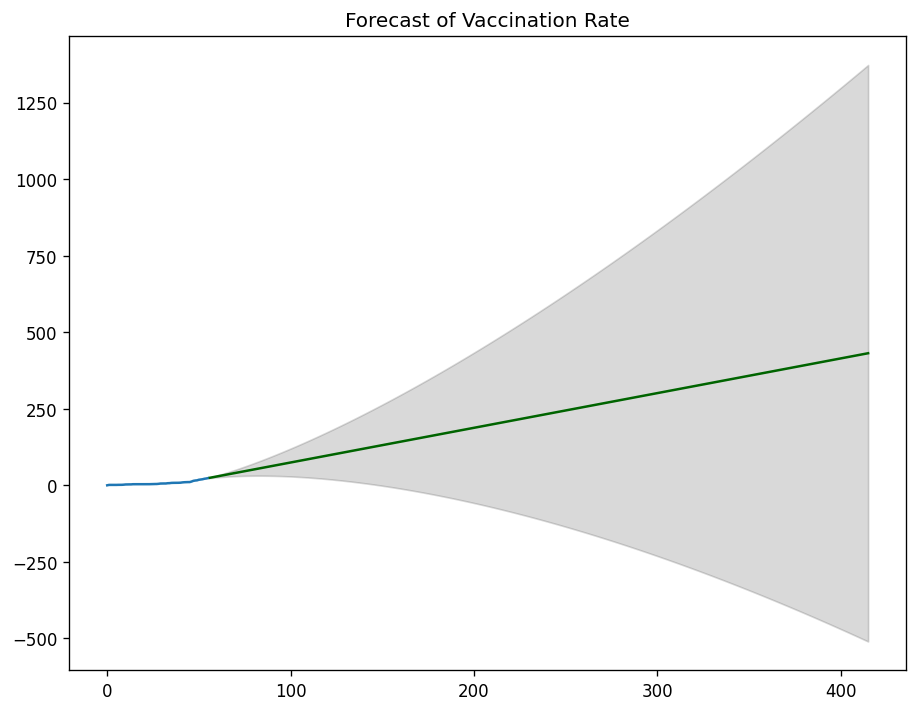

In [8]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
country_list = ['ISL']
for country in country_list:
  df = df.sort_values('location')
  df['eid'] = (df.groupby(['location']).cumcount()==0).astype(int)
  df['eid'] = df['eid'].cumsum()
  ndf=df[df.iso_code==country]
  #check dataframe of GBR
  sndf = ndf.sort_values('people_fully_vaccinated')
  val = sndf['people_fully_vaccinated'].values * 100 /list(ndf.population)[0]

  for i in range(len(val)):
    if val[i]>=0:
      pass
    else :
      end = i
      break
  val = val[:end]
  d = list(sndf.date)[:end]
  fig, axes = plt.subplots(3, 2, sharex=True)
  axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
  plot_acf(val, ax=axes[0, 1])

  # 1st Differencing
  axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
  plot_acf(np.diff(val), ax=axes[1, 1])
  diffval = np.diff(val)

  # 2nd Differencing
  axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
  plot_acf(np.diff(diffval), ax=axes[2, 1])
  plt.show()

  model = pm.auto_arima(val, start_p=1, start_q=1,
  test='adf', # use adftest to find optimal 'd'
  max_p=4, max_q=4, # maximum p and q
  m=1, # frequency of series
  d=None, # let model determine 'd'
  seasonal=False, # No Seasonality
  start_P=0,
  D=0,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)
  print(model.summary())
  # model.plot_diagnostics(figsize=(7,5))
  plt.show()
  n_periods = 12*30
  fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
  index_of_fc = np.arange(len(val), len(val)+n_periods)

  # make series for plotting purpose
  fc_series = pd.Series(fc, index=index_of_fc)
  lower_series = pd.Series(confint[:, 0], index=index_of_fc)
  upper_series = pd.Series(confint[:, 1], index=index_of_fc)
  # Plot
  plt.plot(val)
  plt.plot(fc_series, color='darkgreen')
  plt.fill_between(lower_series.index,
  lower_series,
  upper_series,
  color='k', alpha=.15)
  plt.title("Forecast of Vaccination Rate")
  plt.show()
  for i in range(n_periods):
    date = parse(d[-1]) + datetime.timedelta(days=1)
    d.append(str(date).split()[0])
  y = list(val) + list(fc)
  dfp = pd.DataFrame()
  dfp['date'] = d
  dfp['people_fully_vaccinated'] = y
  dfp.to_csv(f'{country}_predictions.csv')